# CDS: Numerical Methods Assignments

- See lecture notes and documentation on Brightspace for Python and Jupyter basics. If you are stuck, try to google or get in touch via Discord.

- Solutions must be submitted via the Jupyter Hub.

- Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

## Submission

1. Name all team members in the the cell below
2. make sure everything runs as expected
3. **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
4. **run all cells** (in the menubar, select Cell$\rightarrow$Run All)
5. Check all outputs (Out[\*]) for errors and **resolve them if necessary**
6. submit your solutions  **in time (before the deadline)**

## Dynamic Behavior from Hyperbolic PDEs

In the following you will derive and implement finite-difference methods to study generalized hyperbolic partial differential equations.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

### Task 1: finite-difference hyperbolic PDE solver

Our aim is to implement a Python function to find the solution of the following PDE:

\begin{align*}
    \frac{\partial^2}{\partial t^2} u(x,t)
    - \alpha^2 \frac{\partial^2}{\partial x^2} u(x,t) = 0,
    \qquad
    0 \leq x \leq l,
    \qquad
    0 \leq t
\end{align*}

with the boundary conditions

\begin{align*}
    u(0,t) = u(l,t) &= 0, 
    &&\text{for } t > 0 \\
    u(x,0) &= f(x) \\
    \frac{\partial}{\partial t} u(x,0) &= g(x)
    &&\text{for } 0 \leq x \leq l.
\end{align*}
        
By approximating the partial derivatives with finite differences we can recast the problem into the following form
		
\begin{align*}
    \vec{w}_{j+1} = \mathbf{A} \vec{w}_{j}
    - \vec{w}_{j-1}.
\end{align*}

Here $\vec{w}_j$ is a vector of length $m$ in the discretized spatial coordinate $x_i$ at time step $t_j$. The spatial coordinates are defined as $x_i = i h$, where $i=0,1,\dots,m-1$ and $h = l/(m-1)$. The time steps are defined as $t_j = j k$, where $j = 0, 1, \dots, n-1$.

The tri-diagonal matrix $\mathbf{A}$ has size $(m-2)\times(m-2)$ and is defined by

\begin{align*}
    \mathbf{A} =
    \left( \begin{array}{cccc}
        2(1-\lambda^2) & \lambda^2 & & 0\\
        \lambda^2 & \ddots & \ddots &  \\
        & \ddots & \ddots &  \lambda^2 \\
        0 &  & \lambda^2 & 2(1-\lambda^2)  
    \end{array}  \right),
\end{align*}
        
where $\lambda = \alpha k / h$. This $(m-2)\times(m-2)$ structure accounts for the first set of boundary conditions. Note that the product $\mathbf{A} \vec{w}_{j}$ is thus only performed over the $m-2$ subset, i.e. $i=1,2,\dots,m-2$. The other boundary conditions are accounted for by initializing the first two time steps with

\begin{align*}
    w_{i,j=0} &= f(x_i) \\
    w_{i,j=1} &= (1-\lambda^2) f(x_i)
                + \frac{\lambda^2}{2} f(x_{i+1})
                + \frac{\lambda^2}{2} f(x_{i-1})
                + kg(x_i).
\end{align*}
        
Implement a Python function of the form $\text{pdeHyperbolic(a, x, t, f, g)}$, where $\text{a}$ represents the PDE parameter $\alpha$, $\text{x}$ and $\text{t}$ are the discretized spatial and time grids, and $\text{f}$ and $\text{g}$ are the functions defining the boundary conditions. This function should return a two-dimensional array $\text{w[:,:]}$, which stores the spatial vector $\vec{w}_j$ at each time coordinate $t_j$.

In [2]:
def pdeHyperbolic(a, x, t, f, g):
    """
    Numerically solves the hyperbolic differential equation ∂^2u(x,t)/∂t^2 - a*∂^2u(x,t)/∂x^2 = 0
    with constant a for boundary conditions given by
        u(0, t) = 0 = u(x[-1], t) for all t
        y(x, 0) = f(x)
        ∂u(x, t)/∂t = g(x) for t = 0 and all x

    Args:
        a: numerical constant in the PDE
        x: array of evenly spaced space values x in the PDE
        t: array of evenly spaced times values t in the PDE
        f: callable function of numerical x giving a boundary condition to solution u of the PDE
        g: callable function of numerical x giving a boundary condition to derivative ∂u/∂t of the PDE

    Returns:
        An |t| by |x| matrix w giving approximate solutions to the PDE over the grid
        imposed by arrays x and t, such that w[j, i] corresponds to u[x[i], y[j]].
    """
    
    n = len(t)
    m = len(x)
    
    # TODO: The stepsize is defined by fixed h and, but the input x and t
    #       could allow variable step size. What should it be?
    #h = x[1] - x[0]
    l = x[-1]
    h = l/(m - 1)
    k = t[1] - t[0]
    λ = a*k/h
    
    # Create the tri-diagonal matrix A of size (m - 2) by (m - 2).
    A = np.eye(m - 2)*2*(1 - λ**2) + ( np.eye(m - 2, m - 2, 1) + np.eye(m - 2, m - 2, -1) )*λ**2
    
    # Create empty matrix w for the result.
    # The boundary values at x[0] and x[-1] are taken care of this way, too.
    w = np.zeros((n, m))
    
    # Set initial values for w[0, i] and w[1, i] for all i except for the boundaries.
    w[0] = f(x)
    w[1, 1:m - 1] = (1 - λ**2)*f(x[1:m - 1]) + λ**2/2*f(x[2:m]) + λ**2/2*f(x[0:m - 2]) + k*g(x[1:m - 1])
    
    # Loop over all times t[j] to find w[j, i].
    for j in range(2, n):
        w[j, 1:m - 1] = np.dot(A, w[j - 1, 1:m - 1]) - w[j - 2, 1:m - 1]
    
    return w

### Task 2 

Use your implementation to solve the following problems. Compare in the first problem your numerical solution to the analytic one and use it to debug your code.

#### Problem 1:
\begin{align*}
    \frac{\partial^2}{\partial t^2} u(x,t)
    - \frac{\partial^2}{\partial x^2} u(x,t) &= 0,
    &&\text{for }0 \leq x \leq 1 \text{ and } 0 \leq t \leq 1\\
    u(0,t) = u(l,t) &= 0, 
    &&\text{for } t > 0 \\
    u(x,0) &= \operatorname{sin}\left(2 \pi x \right), \\
    \frac{\partial}{\partial t} u(x,0) &=  2 \pi \operatorname{sin}\left(2 \pi x \right)
    &&\text{for } 0 \leq x \leq 1.
\end{align*}

Compare your numerical solution to the analytic one and use it to debug your code. The corresponding analytic solution is

\begin{equation}
    u(x,t) = \operatorname{sin}(2 \pi x) (\operatorname{cos}(2 \pi t) + \operatorname{sin}(2 \pi t)).
\end{equation}

Then write a unit test for your function based on this problem.


On the left, the numerically found solution w is plotted against a grid of equidistant x and t values x_i and t_j.
On the right, the exact solution 𝑢(𝑥,𝑡) = sin(2𝜋𝑥)(cos(2𝜋𝑡)+sin(2𝜋𝑡)) is plotted against the same grid.
In the middle, their difference u - w is shown, again against the same grid.
Do note the order of magnitude of the z axis in the middle as compared to the other plots. The error is quite small.
Increasing the grid density lowers the errors.



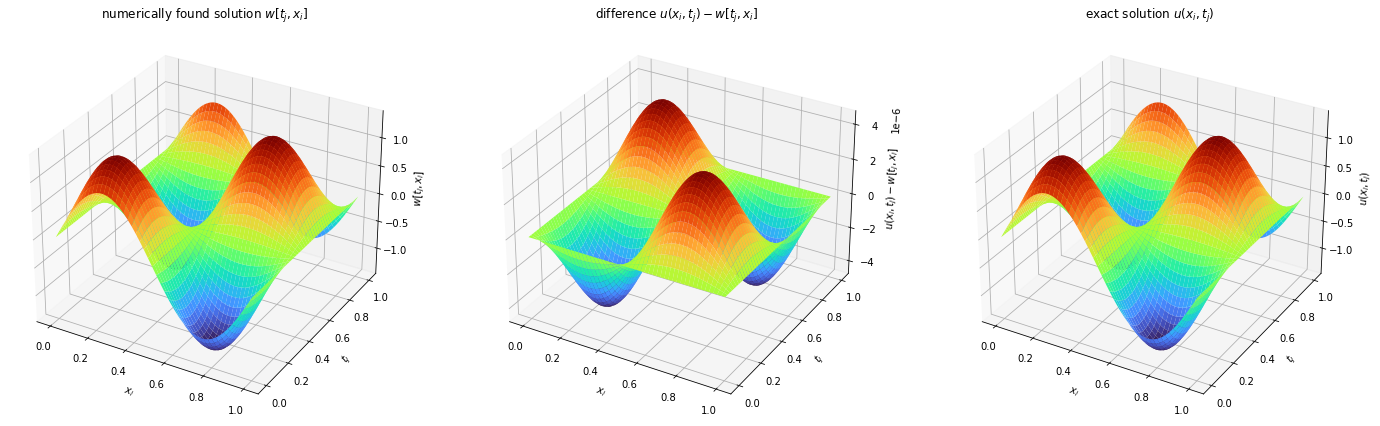

In [3]:
# There is an 𝑙 in the boundary conditions we assume should be a 1.
a = 1
l = 1
x = np.linspace(0, l, 1200)
t = np.linspace(0, 1, 1200)
f = lambda x: np.sin(2*np.pi*x)
g = lambda x: 2*np.pi*np.sin(2*np.pi*x)

w = pdeHyperbolic(a, x, t, f, g)
u = lambda x, t: np.sin(2*np.pi*x)*(np.cos(2*np.pi*t) + np.sin(2*np.pi*t))

# Plot the whole.
fig = plt.figure(figsize=(24, 8))

grid = np.meshgrid(x, t)

# Plot w
ax0 = fig.add_subplot(1, 3, 1, projection='3d')
ax0.plot_surface(*grid, w, cmap="turbo")
ax0.set_title('numerically found solution $w[t_j, x_i]$')
ax0.set_zlabel('$w[t_j, x_i]$')

# Plot the difference u - w
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.plot_surface(*grid, u(*grid) - w, cmap="turbo")
ax1.set_title('difference $u(x_i,t_j) - w[t_j, x_i]$')
ax1.set_zlabel('$u(x_i,t_j) - w[t_j, x_i]$')

# Plot u
ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.plot_surface(*grid, u(*grid), cmap="turbo")
ax2.set_title('exact solution $u(x_i,t_j)$')
ax2.set_zlabel('$u(x_i, t_j)$')

# Set shared settings
for ax in [ax0, ax1, ax2]:
    ax.set_xlabel('$x_i$')
    ax.set_ylabel('$t_j$')

fig.show()

print("""
On the left, the numerically found solution w is plotted against a grid of equidistant x and t values x_i and t_j.
On the right, the exact solution 𝑢(𝑥,𝑡) = sin(2𝜋𝑥)(cos(2𝜋𝑡)+sin(2𝜋𝑡)) is plotted against the same grid.
In the middle, their difference u - w is shown, again against the same grid.
Do note the order of magnitude of the z axis in the middle as compared to the other plots. The error is quite small.
Increasing the grid density lowers the errors.
""")

In [4]:
def test_pdeHyperbolic():
    a = 1
    l = 1
    x = np.linspace(0, l, 1200)
    t = np.linspace(0, 1, 1200)
    f = lambda x: np.sin(2*np.pi*x)
    g = lambda x: 2*np.pi*np.sin(2*np.pi*x)

    w = pdeHyperbolic(a, x, t, f, g)
    u = lambda x, t: np.sin(2*np.pi*x)*(np.cos(2*np.pi*t) + np.sin(2*np.pi*t))
    grid = np.meshgrid(x, t)

    TOL = 1e-5
    assert np.all(np.abs(u(*grid) - w) < TOL)
    
test_pdeHyperbolic()

#### Problem 2:

\begin{align*}
    \frac{\partial^2}{\partial t^2} u(x,t)
    - \frac{\partial^2}{\partial x^2} u(x,t) &= 0,
    &&\text{for }0 \leq x \leq 1 \text{ and } 0 \leq t \leq 2\\
    u(0,t) = u(l,t) &= 0, 
    &&\text{for } t > 0 \\
    u(x,0) &= \left\{ \begin{array}{cc} +1 & \text{for } x<0.5 \\ -1 & \text{for } x \geq 0.5 \end{array} \right., \\
    \frac{\partial}{\partial t} u(x,0) &=  0
    &&\text{for } 0 \leq x \leq 1.
\end{align*}

Use $m=200$ and $n=400$ to discretize the spatial and time grids, respectively.

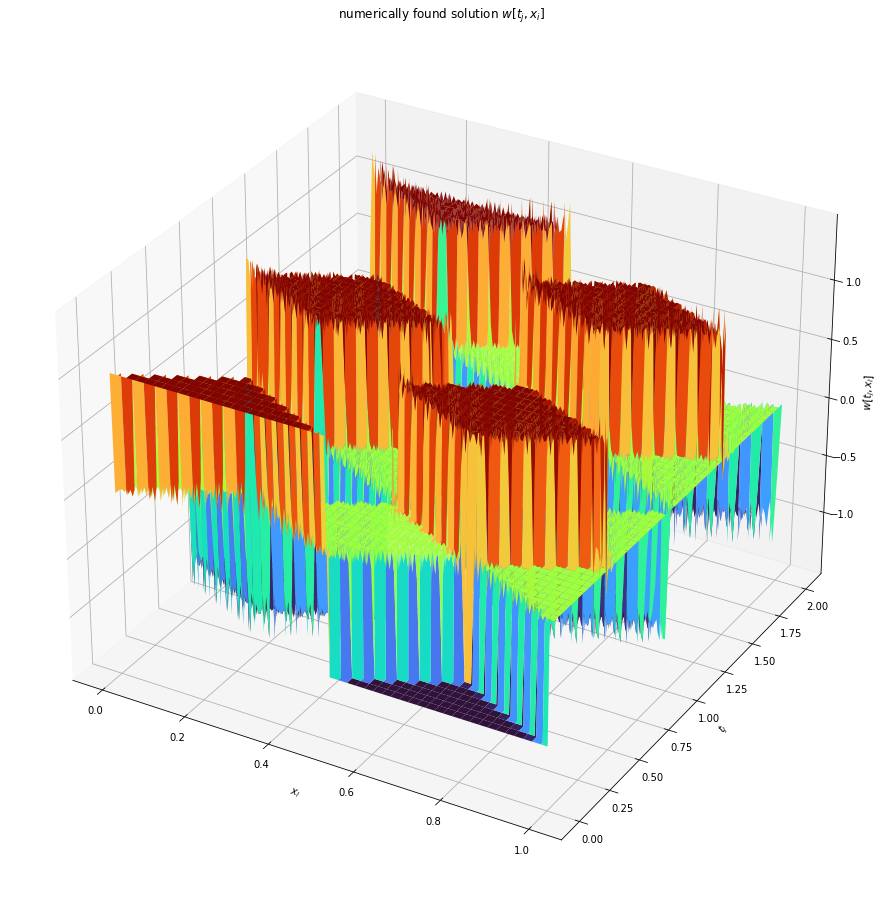

In [5]:
# There is an 𝑙 in the boundary conditions we assume should be a 1.
a = 1
l = 1
m = 200
n = 400
x = np.linspace(0, l, m)
t = np.linspace(0, 2, n)
f = lambda x: -1 + 2.*(x < .5)
g = lambda x: 0

w = pdeHyperbolic(a, x, t, f, g)

# Plot the whole.
fig = plt.figure(figsize=(16, 16))

grid = np.meshgrid(x, t)

# Plot w
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(*grid, w, cmap="turbo")
ax.set_title('numerically found solution $w[t_j, x_i]$')
ax.set_zlabel('$w[t_j, x_i]$')
ax.set_xlabel('$x_i$')
ax.set_ylabel('$t_j$')

fig.show()

# TODO: Are comments really needed?

### Task 3

Animate your solutions! To this end you can use the following code:

```python

# use matplotlib's animation package
import matplotlib.pylab as plt
import matplotlib
import matplotlib.animation as animation
# set the animation style to "jshtml" (for the use in Jupyter)
matplotlib.rcParams['animation.html'] = 'jshtml'

# create a figure for the animation
fig = plt.figure()
plt.grid(True)
plt.xlim( ... )     # fix x limits
plt.ylim( ... )     # fix y limits

# Create an empty plot object and prevent its showing (we will fill it each frame)
myPlot, = plt.plot([0], [0])
plt.close()

# This function is called each frame to generate the animation (f is the frame number)
def animate(f):                   
    myPlot.set_data( ... )  # update plot

# Show the animation
frames = np.arange(1, np.size(t))  # t is the time grid here
myAnimation = animation.FuncAnimation(fig, animate, frames, interval = 20)
myAnimation

```

In [ ]:
# Animate problem 1 here ...

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Animate problem 2 here ...

# YOUR CODE HERE
raise NotImplementedError()